<a href="https://colab.research.google.com/github/naveenk-DS/twitter_sentiment_app.py/blob/main.py/Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cull7

Looking in indexes: https://download.pytorch.org/whl/cull7
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.


ERROR: Could not find a version that satisfies the requirement fsspec (from torch) (from versions: none)
ERROR: No matching distribution found for fsspec


In [ ]:
url= "https://raw.githubusercontent.com/GuviMentor88/Training-Datasets/refs/heads/main/twitter_training.csv"
import streamlit as st
import pandas as pd
df=pd.read_csv(url)

df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
# Assigning column names
df.columns = ['Tweet_id', 'Location', 'Review', 'Tweets']
print(df)

       Tweet_id     Location    Review  \
0          2401  Borderlands  Positive   
1          2401  Borderlands  Positive   
2          2401  Borderlands  Positive   
3          2401  Borderlands  Positive   
4          2401  Borderlands  Positive   
...         ...          ...       ...   
74676      9200       Nvidia  Positive   
74677      9200       Nvidia  Positive   
74678      9200       Nvidia  Positive   
74679      9200       Nvidia  Positive   
74680      9200       Nvidia  Positive   

                                                  Tweets  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized th

In [ ]:
df.shape

(74681, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet_id  74681 non-null  int64 
 1   Location  74681 non-null  object
 2   Review    74681 non-null  object
 3   Tweets    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [ ]:
df.isnull().sum()

Tweet_id      0
Location      0
Review        0
Tweets      686
dtype: int64

In [ ]:
#duplicate
df.duplicated().sum()

2700

In [ ]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [ ]:
df.drop(columns=['Tweet_id', 'Location'], inplace=True)

In [ ]:
# Replace "Irrelevant" with "Neutral"
df['Review'] = df['Review'].replace('Irrelevant', 'Neutral')

# Label Encoding
sentiment_mapping = {'Positive': 1, 'Negative': 2, 'Neutral': 0}
df['Review'] = df['Review'].map(sentiment_mapping)

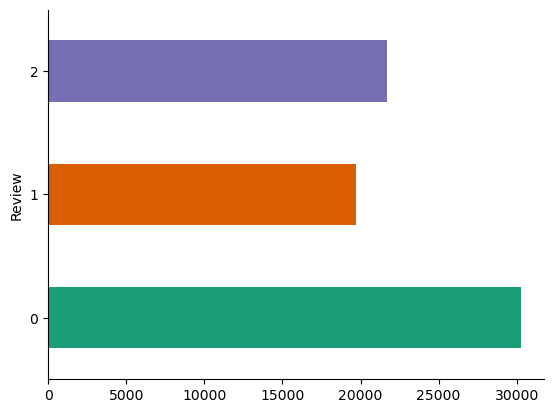

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Review').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.to_csv(r"E:\UDHAYA\Final_Project\Cleaned_Dataset\Cleaned_Tweets_dataset.csv", index=False)

In [ ]:
!pip install torch transformers datasets torch scikit-learn

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda")

In [ ]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load your preprocessed dataset
df = pd.read_csv(r"E:\UDHAYA\Final_Project\Cleaned_Dataset\Cleaned_Tweets_dataset.csv")  # Replace with actual file path

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Tweets'], df['Review'], test_size=0.2, random_state=42
)

# Convert the 'text' column to strings before creating the Dataset
train_texts = train_texts.astype(str)
val_texts = val_texts.astype(str)
# Convert to Dataset objects
train_data = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_data = Dataset.from_dict({"text": val_texts, "label": val_labels})

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

train_data = train_data.map(tokenize_function, batched=True)
val_data = val_data.map(tokenize_function, batched=True)

# Remove unnecessary columns for training
train_data = train_data.remove_columns(['text'])
val_data = val_data.remove_columns(['text'])

Map:   0%|          | 0/57324 [00:00<?, ? examples/s]

Map:   0%|          | 0/14331 [00:00<?, ? examples/s]

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Number of sentiment classes (Positive, Negative, Neutral)
)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Create a PyTorch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    fp16=True
)

C:\Users\akila\anaconda3\envs\gpu_env\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement after 2 epochs
)

# Train the model
trainer.train()

C:\Users\akila\AppData\Local\Temp\ipykernel_26112\2969086742.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\akila\anaconda3\envs\gpu_env\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:403: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.396200,0.447499,0.827856,0.828197,0.827856,0.827309
2,0.207800,0.302091,0.891634,0.892261,0.891634,0.891660
3,0.227500,0.325460,0.906985,0.907476,0.906985,0.906902


TrainOutput(global_step=10749, training_loss=0.3712027873568384, metrics={'train_runtime': 4038.179, 'train_samples_per_second': 42.587, 'train_steps_per_second': 2.662, 'total_flos': 2.278108974281933e+16, 'train_loss': 0.3712027873568384, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print("Evaluation Results:", results)

Evaluation Results: {'eval_loss': 0.30209147930145264, 'eval_accuracy': 0.8916335217360966, 'eval_precision': 0.8922611806722309, 'eval_recall': 0.8916335217360966, 'eval_f1': 0.8916598375248648, 'eval_runtime': 135.661, 'eval_samples_per_second': 105.638, 'eval_steps_per_second': 6.605, 'epoch': 3.0}


In [ ]:
model.save_pretrained("E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert")
tokenizer.save_pretrained("E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert")

('E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert\\tokenizer_config.json',
 'E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert\\special_tokens_map.json',
 'E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert\\vocab.txt',
 'E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert\\added_tokens.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn.functional as F

# Load fine-tuned model and tokenizer
model_path = "E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
def predict_sentiment(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = F.softmax(outputs.logits, dim=-1)

    # Get class probabilities and format the output
    results = []
    for i, prob in enumerate(probs):
        result = {
            "Text": texts[i],
            "Probabilities": {
                "Neutral": round(prob[0].item(), 4),
                "Positive": round(prob[1].item(), 4),
                "Negative": round(prob[2].item(), 4)
            }
        }
        results.append(result)
    return results

In [ ]:
texts = [
    "I love this product!",
    "This is the worst experience ever.",
    "guvi has the best data science road map in industry"
]

predictions = predict_sentiment(texts)

# Display results
for prediction in predictions:
    print(f"Text: {prediction['Text']}")
    for sentiment, prob in prediction["Probabilities"].items():
        print(f"  {sentiment}: {prob}")
    print()

Text: I love this product!
  Neutral: 0.0166
  Positive: 0.9785
  Negative: 0.0049

Text: This is the worst experience ever.
  Neutral: 0.0174
  Positive: 0.0135
  Negative: 0.9691

Text: guvi has the best data science road map in industry
  Neutral: 0.9273
  Positive: 0.0682
  Negative: 0.0045



In [ ]:
!pip install flask

  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)


In [ ]:
import gradio as gr
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from flask import request
import logging
from datetime import datetime

# Load fine-tuned model and tokenizer
model_path = "E:/UDHAYA/Final_Project/Model./fine_tuned_distilbert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Set up logging
logging.basicConfig(
    filename="user_logs.txt",  # Logs will be saved to this file
    level=logging.INFO,
    format="%(asctime)s - %(message)s",
)

def log_user_details(user_ip, input_text):
    log_message = f"IP: {user_ip} | Input: {input_text}"
    logging.info(log_message)
    print(log_message)  # Optional: Print logs for testing in Colab

def predict_sentiment(text):
    # Get user IP address (only works with Flask requests)
    user_ip = request.remote_addr if request else "Unknown IP"
    log_user_details(user_ip, text)

    # Predict sentiment
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1)
    # Get class probabilities and format the output
    result = {
        "Negative": round(probs[0][2].item(), 4),
        "Neutral": round(probs[0][0].item(), 4),
        "Positive": round(probs[0][1].item(), 4),
    }
    return result

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter text here..."),
    outputs=gr.JSON(),
    title="Twitter Tweets Sentiment Analysis",
    description="Enter Tweets and get the predicted sentiment probabilities."
)

iface.launch(share=True)  # `share=True` creates a public URL

Running on local URL:  http://127.0.0.1:7862

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


IP: Unknown IP | Input: good morning!!! I am very HAPPY today
IP: Unknown IP | Input: This is  a Great day!!! Good night all...


In [ ]:
# Read the log file and print its content
log_file_path = "user_logs.txt"

try:
    with open(log_file_path, "r") as log_file:
        logs = log_file.readlines()
        print("User Logs:")
        for line in logs:
            print(line.strip())  # Remove extra newline characters
except FileNotFoundError:
    print(f"Log file '{log_file_path}' not found.")

User Logs:
2025-01-10 20:58:58,159 - HTTP Request: GET http://127.0.0.1:7860/startup-events "HTTP/1.1 200 OK"
2025-01-10 20:58:58,183 - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"
2025-01-10 20:58:58,581 - HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
2025-01-10 20:58:59,146 - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
2025-01-10 20:58:59,468 - HTTP Request: GET https://api.gradio.app/v2/tunnel-request "HTTP/1.1 200 OK"
2025-01-10 20:59:00,123 - HTTP Request: GET https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_windows_amd64.exe "HTTP/1.1 200 OK"
2025-01-10 21:00:30,042 - IP: Unknown IP | Input: I am peaceful!!! but not happy!
2025-01-10 21:01:29,785 - IP: Unknown IP | Input:
2025-01-10 21:01:37,213 - IP: Unknown IP | Input: happy!!
2025-01-10 23:28:27,645 - HTTP Request: GET http://127.0.0.1:7861/startup-events "HTTP/1.1 200 OK"
2025-01-10 23:28:27,683 - HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"
2025